## Downloading the dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Setup and data preparation

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


First we put dataset''s metadata into a pandas dataframe. This dataframe later we be used in order to create a databunch from images.  

In [0]:
df = pd.read_csv("/content/drive/My Drive/data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Next we map dx column to lesion types:

In [0]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion'] = df.dx.map(lesion_type_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


Here we examine the number of images in each of the seven categories of skin lesions.
It is clear that this dataset is imbalanced, with 6705 samples in 'Melanocyctic nevi' class and only 115 'Dermatofibroma' samples.

In [0]:
print(df.lesion.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


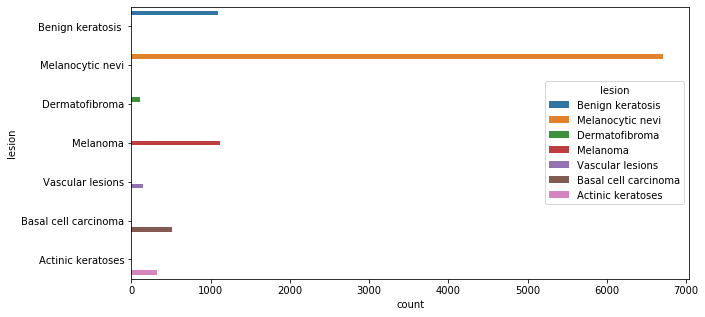

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In order to alleviate the class imabalance issue, we apply random undersampling to classes with over 200 samples:

## Undersampling

In [0]:
num_sample = 200

df_df = df.loc[df['dx'] == "df"][0:115]
df_vasc = df.loc[df['dx'] == "vasc"][0:142]
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample)
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
df = shuffle(df)

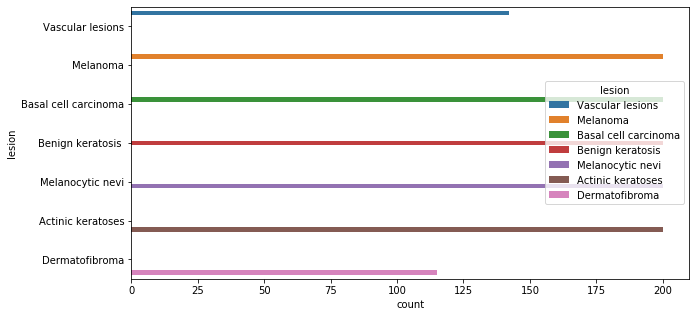

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

Next we create an ImageDataBunch object from sampled dataset and apply common data augmentations to this dataset. We also normalize this dataset using ImageNet stats.

## Loading the data

In [0]:
tfms = get_transforms(flip_vert=True)
data = ImageDataBunch.from_df("/content/drive/My Drive/data",
                              df, fn_col=1, suffix='.jpg', label_col=7, 
                              ds_tfms=tfms, size=224, bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1006 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Vascular lesions,Vascular lesions,Melanoma,Melanoma,Basal cell carcinoma
Path: /content/drive/My Drive/data;

Valid: LabelList (251 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Melanoma,Melanocytic nevi,Vascular lesions,Actinic keratoses,Benign keratosis 
Path: /content/drive/My Drive/data;

Test: None

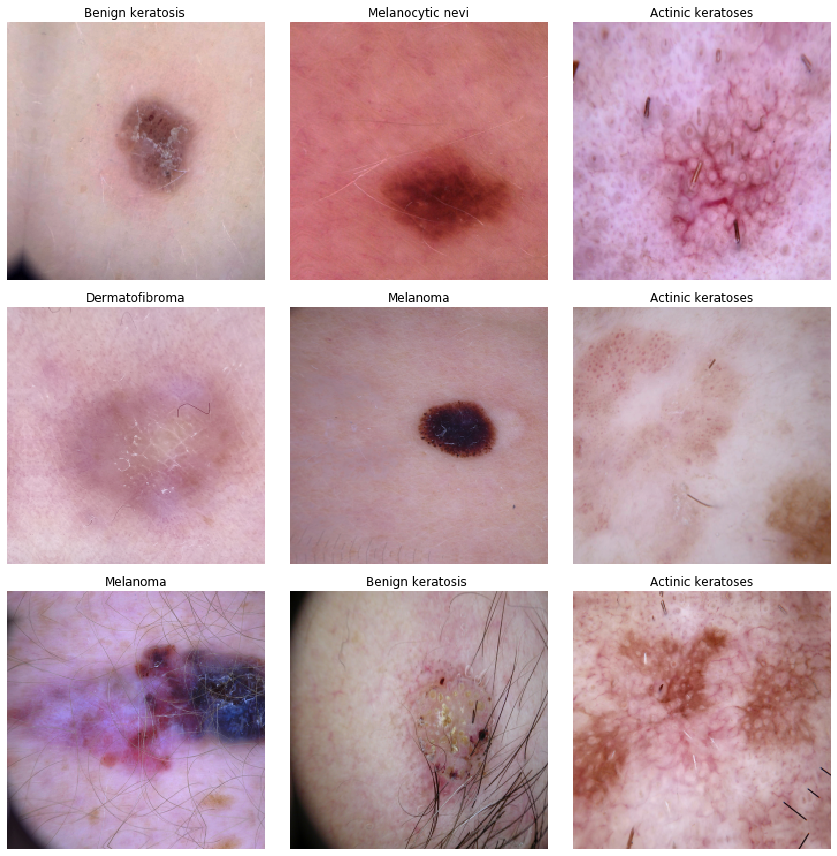

In [0]:
data.show_batch(rows=3)

In [0]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras

width = 28
height = 28
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(width,height,1)))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(10, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


## Model training and evaluation

Now we create a Learner object using a freezed pretrained densenet169 architecture:

In [0]:
learner = cnn_learner(data, models.densenet169, metrics=[accuracy, FBeta(average='macro')], model_dir="../models/")
learner.loss_func = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:03<00:00, 16.1MB/s]


Before starting the training process, let's find the optimum learning rate using learning rate finder.
The plot shows that the steepest decrease in the loss value happens when learning rate is around 1e-03 value.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


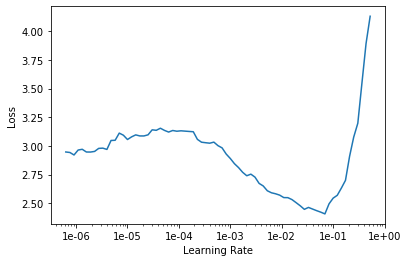

In [16]:
learner.lr_find()
learner.recorder.plot()

Now we train the model using the optimum learning rate. We also save the best model according to the accuracy of each epoch. Later we use this file to productionize our classifier:

In [0]:
learner.fit_one_cycle(30,1e-3, callbacks=[SaveModelCallback(learner, every='improvement', monitor='accuracy', name='model_best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.092707,0.484771,0.876494,0.882159,00:39
1,0.086744,0.447006,0.868526,0.874947,00:41
2,0.097872,0.492123,0.852590,0.860137,00:39
3,0.109759,0.567704,0.864542,0.871232,00:38
4,0.140033,0.698934,0.828685,0.836666,00:38
5,0.167904,0.616812,0.820717,0.827722,00:38
6,0.197268,0.698710,0.844622,0.852157,00:37
7,0.219432,0.594140,0.828685,0.833344,00:37
8,0.262336,0.509325,0.868526,0.877034,00:37
9,0.202308,0.556278,0.856574,0.864553,00:37


Better model found at epoch 0 with accuracy value: 0.8764940500259399.
Better model found at epoch 15 with accuracy value: 0.8804780840873718.
Better model found at epoch 16 with accuracy value: 0.892430305480957.
Better model found at epoch 19 with accuracy value: 0.9043824672698975.
Better model found at epoch 25 with accuracy value: 0.9083665609359741.


As you can see, the best model found at epoxh 19 and the with accuracy of around %91.2 and f-measure of %91.7

## Model interpretation

In [0]:
learner = learner.load("model_best")

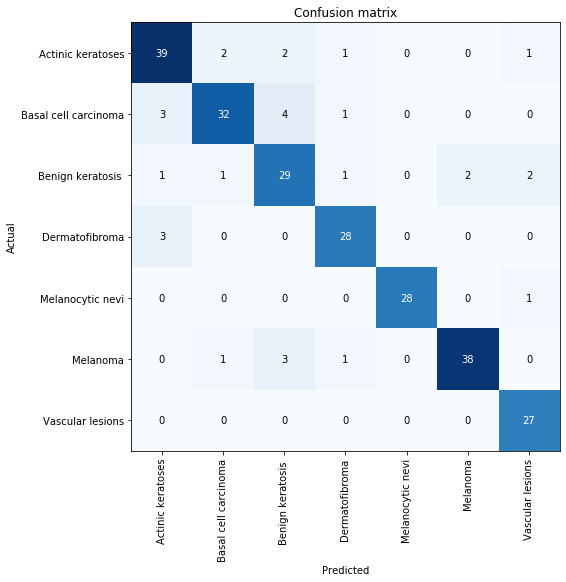

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [0]:
interp.most_confused()

[('Basal cell carcinoma', 'Benign keratosis ', 4),
 ('Basal cell carcinoma', 'Actinic keratoses', 3),
 ('Dermatofibroma', 'Actinic keratoses', 3),
 ('Melanoma', 'Benign keratosis ', 3),
 ('Actinic keratoses', 'Basal cell carcinoma', 2),
 ('Actinic keratoses', 'Benign keratosis ', 2),
 ('Benign keratosis ', 'Melanoma', 2),
 ('Benign keratosis ', 'Vascular lesions', 2),
 ('Actinic keratoses', 'Dermatofibroma', 1),
 ('Actinic keratoses', 'Vascular lesions', 1),
 ('Basal cell carcinoma', 'Dermatofibroma', 1),
 ('Benign keratosis ', 'Actinic keratoses', 1),
 ('Benign keratosis ', 'Basal cell carcinoma', 1),
 ('Benign keratosis ', 'Dermatofibroma', 1),
 ('Melanocytic nevi', 'Vascular lesions', 1),
 ('Melanoma', 'Basal cell carcinoma', 1),
 ('Melanoma', 'Dermatofibroma', 1)]

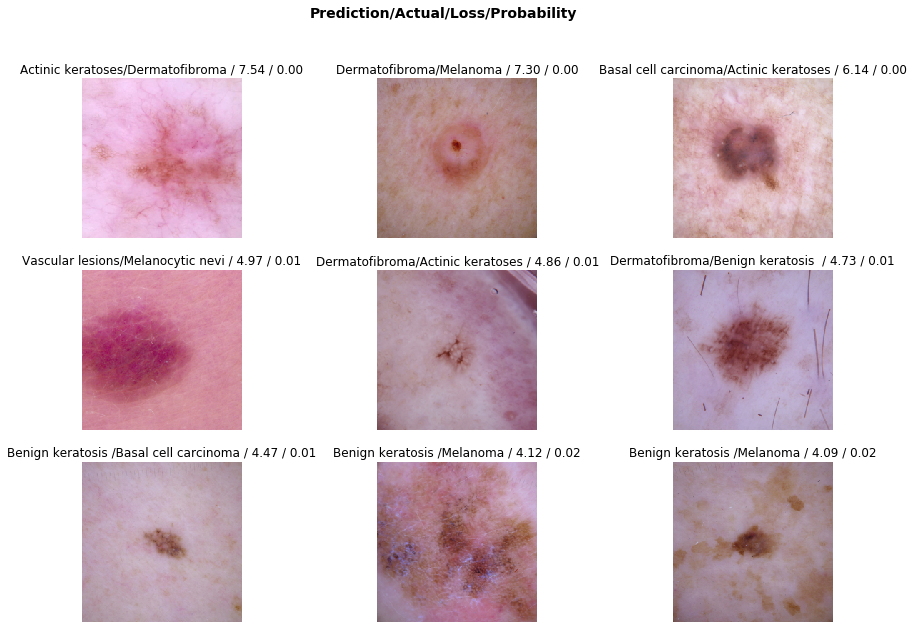

In [0]:
interp.plot_top_losses(9, figsize=(15,10), heatmap=False)